# Importing required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Data Loading and Preprocessing

# --Data Labelling
    Fractured X-ray image-> Positive 
    Normal X-ray image-> Negative 
    
### -- Normalized the data 
### -- Resizing images to 224*224
### -- Data Generator

In [6]:
def load_data(base_dir, category):
    data = []
    labels = []
    for label in ['negative', 'positive']:
        path = os.path.join(base_dir, category)
        file_paths = glob(os.path.join(path, '**', f'*_{label}'), recursive=True)
        for file_path in file_paths:
            for img in glob(os.path.join(file_path, '*.png')):
                data.append(img)
                if label == 'negative':
                    labels.append('normal')
                else:
                    labels.append('fractured')
                    
    return pd.DataFrame({'image_path': data, 'label': labels})

# Define directories and category
train_dir = 'MURA-v1.1/train'
valid_dir = 'MURA-v1.1/valid'
category = 'XR_ELBOW'

# Loading the data in dataframe for both training and validation
train_df = load_data(train_dir, category)
valid_df = load_data(valid_dir, category)

# Testing to check data loading
print(train_df.head())
print(valid_df.head())


                                          image_path   label
0  MURA-v1.1/train\XR_ELBOW\patient00011\study1_n...  normal
1  MURA-v1.1/train\XR_ELBOW\patient00011\study1_n...  normal
2  MURA-v1.1/train\XR_ELBOW\patient00011\study1_n...  normal
3  MURA-v1.1/train\XR_ELBOW\patient00026\study1_n...  normal
4  MURA-v1.1/train\XR_ELBOW\patient00026\study1_n...  normal
                                          image_path   label
0  MURA-v1.1/valid\XR_ELBOW\patient11204\study1_n...  normal
1  MURA-v1.1/valid\XR_ELBOW\patient11204\study1_n...  normal
2  MURA-v1.1/valid\XR_ELBOW\patient11205\study1_n...  normal
3  MURA-v1.1/valid\XR_ELBOW\patient11205\study1_n...  normal
4  MURA-v1.1/valid\XR_ELBOW\patient11205\study1_n...  normal


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator setup
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',  # for 'normal' and 'fractured' labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification based on the string labels
)

# Flow from DataFrame for validation
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 4931 validated image filenames belonging to 2 classes.
Found 465 validated image filenames belonging to 2 classes.


# Data Visualization

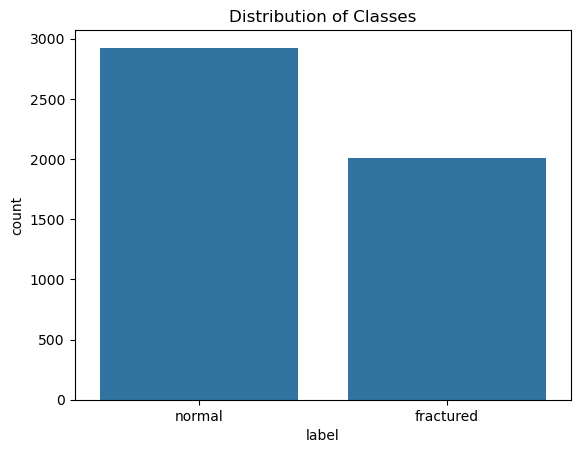

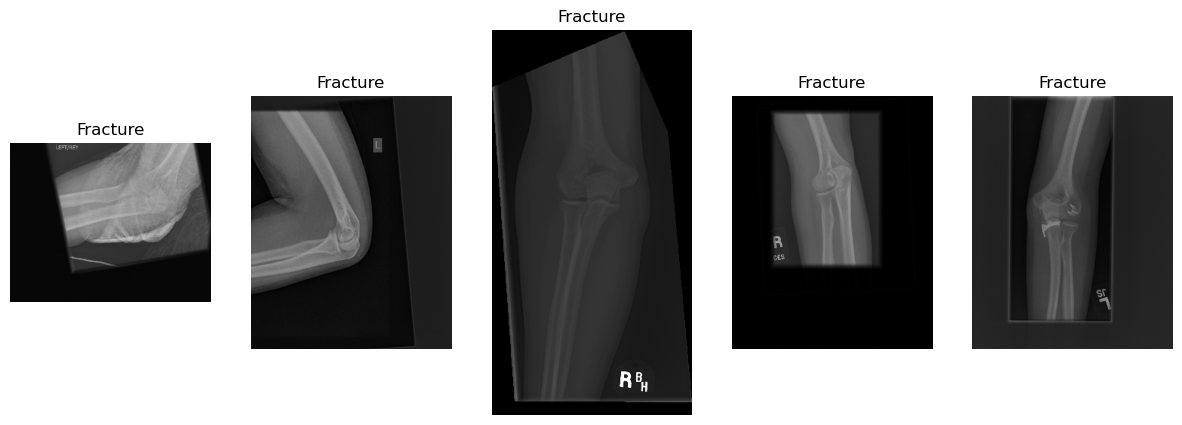

In [7]:
def visualize_data(df):
    sns.countplot(x='label', data=df)
    plt.title('Distribution of Classes')
    plt.show()

    sample_images = df.sample(5)
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images['image_path']):
        img = plt.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title('Fracture' if sample_images.iloc[i]['label'] else 'Normal')
        plt.axis('off')
    plt.show()

visualize_data(train_df)


# Model Implementation

## 1. CNN

In [10]:
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
cnn_model = build_cnn_model(input_shape)

cnn_history = cnn_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 72s 453ms/step - accuracy: 0.5634 - loss: 0.7973 - val_accuracy: 0.5419 - val_loss: 0.6950
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 439ms/step - accuracy: 0.6261 - loss: 0.6409 - val_accuracy: 0.5290 - val_loss: 0.6873
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 71s 456ms/step - accuracy: 0.6526 - loss: 0.6029 - val_accuracy: 0.5269 - val_loss: 0.7400
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 70s 448ms/step - accuracy: 0.7233 - loss: 0.5383 - val_accuracy: 0.5591 - val_loss: 0.7840
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 71s 453ms/step - accuracy: 0.7990 - loss: 0.4233 - val_accuracy: 0.5484 - val_loss: 0.9598


# HyperParameter tuning

In [ ]:
# Manual Hyperparameter Tuning for CNN Model
def build_cnn_model_with_hyperparams(input_shape, learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Trying different learning rates
learning_rates = [0.001]

for lr in learning_rates:
    print(f'Training CNN Model with learning rate: {lr}')
    cnn_model = build_cnn_model_with_hyperparams(input_shape, learning_rate=lr)
    cnn_history = cnn_model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    # Evaluate the model
    evaluate_model(cnn_model, valid_generator)


# Model Evaluation & Prediction

In [11]:
def evaluate_model(model, valid_generator):
    val_predictions = model.predict(valid_generator)
    val_predictions = (val_predictions > 0.5).astype(int)
    
    print('Confusion Matrix')
    print(confusion_matrix(valid_generator.labels, val_predictions))
    
    print('Classification Report')
    print(classification_report(valid_generator.labels, val_predictions))

print("CNN Model Evaluation")
evaluate_model(cnn_model, valid_generator)


CNN Model Evaluation
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Confusion Matrix
[[ 33 197]
 [ 32 203]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.14      0.22       230
           1       0.51      0.86      0.64       235

    accuracy                           0.51       465
   macro avg       0.51      0.50      0.43       465
weighted avg       0.51      0.51      0.43       465



# Model Accuracy & Loss plots

In [12]:
# Plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} Loss')

    plt.show()


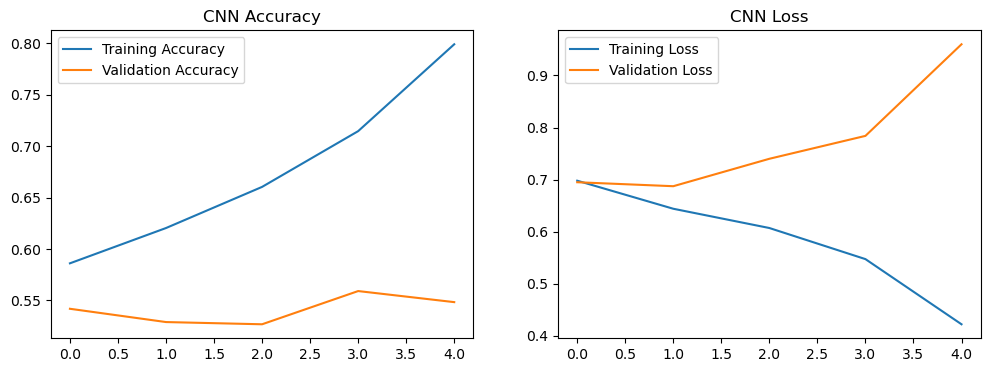

In [14]:
plot_history(cnn_history, "CNN")

# 2. Resnet 50

In [15]:
def build_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet_model(input_shape)

resnet_history = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 142s 877ms/step - accuracy: 0.5372 - loss: 0.7715 - val_accuracy: 0.5054 - val_loss: 0.7840
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 856ms/step - accuracy: 0.5579 - loss: 0.6963 - val_accuracy: 0.5419 - val_loss: 0.6778
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 135s 864ms/step - accuracy: 0.5631 - loss: 0.6927 - val_accuracy: 0.5290 - val_loss: 0.7229
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 134s 857ms/step - accuracy: 0.5733 - loss: 0.6916 - val_accuracy: 0.5419 - val_loss: 0.6759
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 854ms/step - accuracy: 0.5823 - loss: 0.6793 - val_accuracy: 0.5312 - val_loss: 0.7258


## Resnet50 HyperParameter tuning, Evaluation & Prediction

In [17]:
# Tuning the learning rate
learning_rates = [0.001]

for lr in learning_rates:
    print(f'Training ResNet50 Model with learning rate: {lr}')
    resnet_model = build_resnet_model(input_shape)
    optimizer = optimizers.Adam(learning_rate=lr)
    resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    resnet_history = resnet_model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=5,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    # Evaluate the model
    evaluate_model(resnet_model, valid_generator)


Training ResNet50 Model with learning rate: 0.001
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 141s 873ms/step - accuracy: 0.5681 - loss: 0.7235 - val_accuracy: 0.5419 - val_loss: 0.6772
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 135s 871ms/step - accuracy: 0.5589 - loss: 0.6933 - val_accuracy: 0.5419 - val_loss: 0.6720
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 135s 864ms/step - accuracy: 0.5889 - loss: 0.6787 - val_accuracy: 0.5785 - val_loss: 0.6736
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 134s 862ms/step - accuracy: 0.5551 - loss: 0.6904 - val_accuracy: 0.5376 - val_loss: 0.6962
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 135s 865ms/step - accuracy: 0.5894 - loss: 0.6745 - val_accuracy: 0.5419 - val_loss: 0.6734
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 903ms/step
Confusion Matrix
[[  7 223]
 [ 10 225]]
Classification Report
              precision    recall  f1-score   support

           0       0.41      0.03      0.06       230
           1       0.50      0.96      0.66       235

    accuracy               

In [18]:
print("ResNet50 Model Evaluation")
evaluate_model(resnet_model, valid_generator)


ResNet50 Model Evaluation
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step
Confusion Matrix
[[  8 222]
 [  9 226]]
Classification Report
              precision    recall  f1-score   support

           0       0.47      0.03      0.06       230
           1       0.50      0.96      0.66       235

    accuracy                           0.50       465
   macro avg       0.49      0.50      0.36       465
weighted avg       0.49      0.50      0.37       465



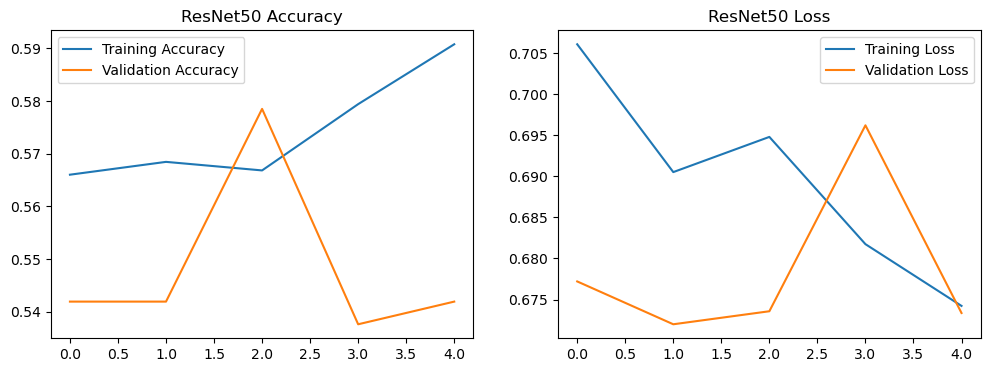

In [19]:
plot_history(resnet_history, "ResNet50")

# DenseNet

In [20]:
def build_densenet_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

densenet_model = build_densenet_model(input_shape)

densenet_history = densenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 147s 873ms/step - accuracy: 0.6641 - loss: 0.6341 - val_accuracy: 0.7376 - val_loss: 0.5334
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 852ms/step - accuracy: 0.7476 - loss: 0.5150 - val_accuracy: 0.7763 - val_loss: 0.5005
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 852ms/step - accuracy: 0.7663 - loss: 0.5015 - val_accuracy: 0.8000 - val_loss: 0.4685
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 132s 846ms/step - accuracy: 0.7709 - loss: 0.4881 - val_accuracy: 0.7849 - val_loss: 0.4889
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 851ms/step - accuracy: 0.7828 - loss: 0.4855 - val_accuracy: 0.7720 - val_loss: 0.4945


## Resnet50 HyperParameter tuning, Evaluation & Prediction

In [21]:
# Tuning the learning rate
learning_rates = [0.001,0.0001]

for lr in learning_rates:
    print(f'Training DenseNet Model with learning rate: {lr}')
    densenet_model = build_densenet_model(input_shape)
    optimizer = optimizers.Adam(learning_rate=lr)
    densenet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    densenet_history = densenet_model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=5,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    # Evaluate the model
    evaluate_model(densenet_model, valid_generator)


Training DenseNet Model with learning rate: 0.001
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 147s 874ms/step - accuracy: 0.6350 - loss: 0.7867 - val_accuracy: 0.7204 - val_loss: 0.5540
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 856ms/step - accuracy: 0.7277 - loss: 0.5443 - val_accuracy: 0.7634 - val_loss: 0.5063
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 856ms/step - accuracy: 0.7588 - loss: 0.5046 - val_accuracy: 0.7785 - val_loss: 0.4948
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 134s 860ms/step - accuracy: 0.7694 - loss: 0.4978 - val_accuracy: 0.7828 - val_loss: 0.4850
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 133s 856ms/step - accuracy: 0.7786 - loss: 0.4825 - val_accuracy: 0.7720 - val_loss: 0.4920
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 933ms/step
Confusion Matrix
[[105 125]
 [ 90 145]]
Classification Report
              precision    recall  f1-score   support

           0       0.54      0.46      0.49       230
           1       0.54      0.62      0.57       235

    accuracy               

In [22]:
print("DenseNet Model Evaluation")
evaluate_model(densenet_model, valid_generator)


DenseNet Model Evaluation
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 769ms/step
Confusion Matrix
[[ 92 138]
 [ 95 140]]
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       230
           1       0.50      0.60      0.55       235

    accuracy                           0.50       465
   macro avg       0.50      0.50      0.49       465
weighted avg       0.50      0.50      0.49       465



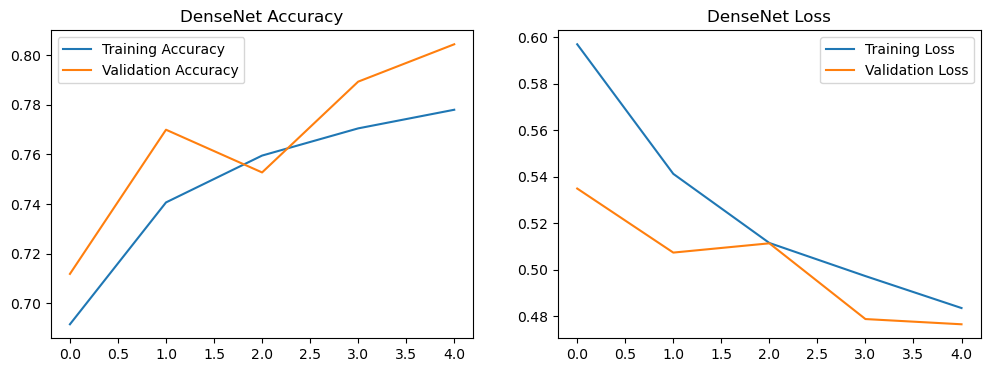

In [23]:
plot_history(densenet_history, "DenseNet")